In [53]:
import pandas as pd
import numpy as np
import os
import pdb
import math
import copy
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.cluster import SpectralClustering



pd.set_option('display.max_columns', None) # To display all columns

# 1. Load the data

In [2]:
# read the dataframe from the pickle file
with open('norm_signals.pkl', 'rb') as f:
    norm_signals = pickle.load(f) 

with open('datas_df.pkl', 'rb') as f:
    datas = pickle.load(f)     
    

In [3]:
datas.head(5)

,D,Sub_D,ID,Round,Phase,BVP,EDA,HR,TEMP,participant_ID,puzzler,team_ID,E4_nr,upset,hostile,alert,ashamed,inspired,nervous,determined,attentive,afraid,active,frustrated,difficulty,participant
0,1,0,1,1,1,"[-61.33, -56.25, -47.83, -35.69, -20.53, -4.1,...","[0.185827, 0.203768, 0.192234, 0.189671, 0.185...","[76.75, 76.75, 76.73, 76.72, 76.72, 76.7, 76.7...","[30.97, 30.97, 30.97, 30.97, 31.01, 31.01, 31....",7,1,2,A0388C,1,1,2,1,2,2,3,3,1,2,1,0.0,D1_0_id1
1,1,0,1,1,2,"[-3.4, -12.83, -15.64, -14.6, -13.47, -15.57, ...","[0.372935, 0.370372, 0.3678079999999999, 0.367...","[99.05, 98.98, 98.87, 98.73, 98.62, 98.37, 98....","[32.25, 32.25, 32.29, 32.29, 32.29, 32.29, 32....",7,1,2,A0388C,1,1,1,1,3,1,3,2,1,3,2,5.0,D1_0_id1
2,1,0,1,1,3,"[-9.1, 6.31, 16.96, 24.92, 33.21, 44.33, 59.3,...","[0.439576, 0.421634, 0.419071, 0.419071, 0.420...","[84.42, 84.42, 84.42, 84.43, 84.68, 84.95, 85....","[32.97, 32.97, 32.97, 32.95, 32.95, 32.95, 32....",7,1,2,A0388C,1,1,1,1,2,1,2,2,1,1,3,0.0,D1_0_id1
3,1,0,1,2,1,"[-110.39, -93.89, -78.44, -66.28, -57.98, -52....","[0.494683, 0.494683, 0.494683, 0.494683, 0.497...","[76.33, 76.52, 76.52, 76.58, 76.67, 76.78, 76....","[33.37, 33.37, 33.37, 33.37, 33.34, 33.34, 33....",7,1,2,A0388C,1,1,1,1,2.0,1,3,2,1,1,4,0.0,D1_0_id1
4,1,0,1,2,2,"[38.31, 44.5, 50.35, 55.65, 60.11, 63.63, 66.4...","[0.391144, 0.4052409999999999, 0.403959, 0.401...","[83.53, 83.65, 83.85, 84.03, 84.22, 84.42, 84....","[33.71, 33.71, 33.71, 33.68, 33.68, 33.68, 33....",7,1,2,A0388C,1,1,2,1,2,1,3,3,1,3,1,2.0,D1_0_id1


# 2. Prepare the data for clustering

### 2.1. Physiological variables

In [4]:
# define a function to split the list into sublists of size 10 and calculate mean, median, and std
def split_and_calculate(lst):
    sublists = [lst[i:i+15] for i in range(0, len(lst), 15)]
    means = [np.mean(sublist) for sublist in sublists]
    stds = [np.std(sublist) for sublist in sublists]
    medians = [np.median(sublist) for sublist in sublists]
    return means, stds, medians

# split each list column and calculate mean, median, and std for each sublist
temp_data = norm_signals['TEMP'].apply(split_and_calculate)
hr_data = norm_signals['HR'].apply(split_and_calculate)
bvp_data = norm_signals['BVP'].apply(split_and_calculate)
eda_data = norm_signals['EDA'].apply(split_and_calculate)

# create new columns for each mean, std, and median value
for i in range(18):
    norm_signals[f'TEMP_mean_{i+1}'] = [data[0][i] for data in temp_data]
    norm_signals[f'TEMP_sd_{i+1}'] = [data[1][i] for data in temp_data]
    norm_signals[f'TEMP_median_{i+1}'] = [data[2][i] for data in temp_data]
    
    norm_signals[f'HR_mean_{i+1}'] = [data[0][i] for data in hr_data]
    norm_signals[f'HR_sd_{i+1}'] = [data[1][i] for data in hr_data]
    norm_signals[f'HR_median_{i+1}'] = [data[2][i] for data in hr_data]
    
    norm_signals[f'BVP_mean_{i+1}'] = [data[0][i] for data in bvp_data]
    norm_signals[f'BVP_sd_{i+1}'] = [data[1][i] for data in bvp_data]
    norm_signals[f'BVP_median_{i+1}'] = [data[2][i] for data in bvp_data]
    
    norm_signals[f'EDA_mean_{i+1}'] = [data[0][i] for data in eda_data]
    norm_signals[f'EDA_sd_{i+1}'] = [data[1][i] for data in eda_data]
    norm_signals[f'EDA_median_{i+1}'] = [data[2][i] for data in eda_data]

C:\Users\34649\AppData\Local\Temp\ipykernel_4028\2847863269.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  norm_signals[f'TEMP_median_{i+1}'] = [data[2][i] for data in temp_data]
C:\Users\34649\AppData\Local\Temp\ipykernel_4028\2847863269.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  norm_signals[f'HR_mean_{i+1}'] = [data[0][i] for data in hr_data]
C:\Users\34649\AppData\Local\Temp\ipykernel_4028\2847863269.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inser

The results with these many variables were very bad, so we tried reducing dimensionality by dropping the standard deviation

In [5]:
# Filter the columns containing the words "median" or "sd"
# median_sd_cols = norm_signals.filter(regex='median|sd').columns
median_sd_cols = norm_signals.filter(regex='sd').columns

# Drop the filtered columns from the dataframe
norm_signals_mean_med = norm_signals.drop(columns=median_sd_cols)


Drop also the columns we won't use for clustering

In [6]:
# Drop the columns that do not contain the physiological variables
only_physio = norm_signals_mean_med.drop(['TEMP', 'HR', 'BVP', 'EDA','participant', 'Round', 'Phase'], axis=1)

In [7]:
only_physio

,TEMP_mean_1,TEMP_median_1,HR_mean_1,HR_median_1,BVP_mean_1,BVP_median_1,EDA_mean_1,EDA_median_1,TEMP_mean_2,TEMP_median_2,HR_mean_2,HR_median_2,BVP_mean_2,BVP_median_2,EDA_mean_2,EDA_median_2,TEMP_mean_3,TEMP_median_3,HR_mean_3,HR_median_3,BVP_mean_3,BVP_median_3,EDA_mean_3,EDA_median_3,TEMP_mean_4,TEMP_median_4,HR_mean_4,HR_median_4,BVP_mean_4,BVP_median_4,EDA_mean_4,EDA_median_4,TEMP_mean_5,TEMP_median_5,HR_mean_5,HR_median_5,BVP_mean_5,BVP_median_5,EDA_mean_5,EDA_median_5,TEMP_mean_6,TEMP_median_6,HR_mean_6,HR_median_6,BVP_mean_6,BVP_median_6,EDA_mean_6,EDA_median_6,TEMP_mean_7,TEMP_median_7,HR_mean_7,HR_median_7,BVP_mean_7,BVP_median_7,EDA_mean_7,EDA_median_7,TEMP_mean_8,TEMP_median_8,HR_mean_8,HR_median_8,BVP_mean_8,BVP_median_8,EDA_mean_8,EDA_median_8,TEMP_mean_9,TEMP_median_9,HR_mean_9,HR_median_9,BVP_mean_9,BVP_median_9,EDA_mean_9,EDA_median_9,TEMP_mean_10,TEMP_median_10,HR_mean_10,HR_median_10,BVP_mean_10,BVP_median_10,EDA_mean_10,EDA_median_10,TEMP_mean_11,TEMP_median_11,HR_mean_11,HR_median_11,BVP_mean_11,BVP_median_11,EDA_mean_11,EDA_median_11,TEMP_mean_12,TEMP_median_12,HR_mean_12,HR_median_12,BVP_mean_12,BVP_median_12,EDA_mean_12,EDA_median_12,TEMP_mean_13,TEMP_median_13,HR_mean_13,HR_median_13,BVP_mean_13,BVP_median_13,EDA_mean_13,EDA_median_13,TEMP_mean_14,TEMP_median_14,HR_mean_14,HR_median_14,BVP_mean_14,BVP_median_14,EDA_mean_14,EDA_median_14,TEMP_mean_15,TEMP_median_15,HR_mean_15,HR_median_15,BVP_mean_15,BVP_median_15,EDA_mean_15,EDA_median_15,TEMP_mean_16,TEMP_median_16,HR_mean_16,HR_median_16,BVP_mean_16,BVP_median_16,EDA_mean_16,EDA_median_16,TEMP_mean_17,TEMP_median_17,HR_mean_17,HR_median_17,BVP_mean_17,BVP_median_17,EDA_mean_17,EDA_median_17,TEMP_mean_18,TEMP_median_18,HR_mean_18,HR_median_18,BVP_mean_18,BVP_median_18,EDA_mean_18,EDA_median_18
0,0.054804,0.054799,0.053993,0.053990,-0.002207,0.004317,0.001542,0.001528,0.054986,0.054983,0.053654,0.053546,-0.000154,-0.001203,0.001511,0.001513,0.055281,0.055419,0.053662,0.053609,0.001776,-0.004922,0.001541,0.001536,0.055440,0.055425,0.054102,0.054171,-0.000258,-0.000189,0.001633,0.001635,0.055410,0.055394,0.054944,0.055002,-0.000491,0.001038,0.001634,0.001634,0.055409,0.055393,0.056465,0.056587,-0.000971,0.001328,0.001658,0.001657,0.055406,0.055417,0.056501,0.056369,0.003465,0.003231,0.001703,0.001688,0.055467,0.055455,0.056208,0.056127,0.006487,-0.001725,0.001684,0.001673,0.055448,0.055447,0.057404,0.057512,-0.006763,0.000392,0.001798,0.001817,0.055396,0.055409,0.058330,0.058124,0.000136,-0.000626,0.001849,0.001848,0.055366,0.055369,0.061128,0.061345,0.000783,0.000050,0.001900,0.001910,0.055339,0.055332,0.062689,0.062804,-0.000257,-0.000324,0.001950,0.001960,0.055303,0.055294,0.062046,0.061986,-0.000299,-0.000498,0.001965,0.001967,0.055270,0.055276,0.060318,0.060497,0.000658,-0.000205,0.001945,0.001942,0.055248,0.055238,0.058007,0.057954,-0.001168,-0.000840,0.001955,0.001955,0.055214,0.055216,0.057383,0.057322,-0.000123,0.000191,0.001946,0.001946,0.055194,0.055203,0.057303,0.057301,0.001002,0.003114,0.002007,0.002016,0.055169,0.055168,0.058031,0.057989,-0.000858,0.000602,0.002017,0.002016
1,0.057053,0.057046,0.068362,0.068704,-0.000746,0.000069,0.003078,0.003071,0.057155,0.057146,0.063305,0.063462,-0.000786,-0.000926,0.003257,0.003296,0.057249,0.057242,0.060000,0.059877,-0.000306,-0.002338,0.003257,0.003258,0.057282,0.057279,0.059655,0.059753,-0.001345,-0.002238,0.003276,0.003285,0.057345,0.057353,0.059714,0.059575,0.000055,-0.000637,0.003250,0.003268,0.057403,0.057406,0.062008,0.061800,0.003000,0.000346,0.003159,0.003147,0.057454,0.057454,0.064165,0.064235,-0.002177,-0.006885,0.003201,0.003206,0.057512,0.057520,0.064688,0.064610,-0.000182,-0.004830,0.003157,0.003168,0.057561,0.057552,0.063490,0.063636,-0.000453,-0.012182,0.003162,0.003166,0.057608,0.057604,0.059657,0.059675,-0.000198,0.004845,0.003194,0.003191,0.057672,0.057665,0.056796,0.056757,0.003282,0.008499,0.003245,0.003239,0.057712,0.057708,0.055108,0.054947,-0.000487,-0.003187,0.003270,0.00326

### 2.2. Questionnaire variables

In [8]:
question = datas.drop(['D', 'Sub_D', 'ID', 'Round','Phase', 'BVP', 'EDA', 'HR', 'TEMP', 'participant_ID', 'puzzler', 'team_ID', 'E4_nr', 'participant'], axis=1)

In [9]:
question

,upset,hostile,alert,ashamed,inspired,nervous,determined,attentive,afraid,active,frustrated,difficulty
0,1,1,2,1,2,2,3,3,1,2,1,0.0
1,1,1,1,1,3,1,3,2,1,3,2,5.0
2,1,1,1,1,2,1,2,2,1,1,3,0.0
3,1,1,1,1,2.0,1,3,2,1,1,4,0.0
4,1,1,2,1,2,1,3,3,1,3,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
307,1,1,2,1,2,1,2,2,1,2,0,1.0
308,1,1,1,1,1,1,1,1,1,1,0,0.0
309,1,1,2,1,2,1,2,2,1,2,0,0.0
310,1,1,2,1,2,2,2,2,1,2,1,2.0


NaN values

In [10]:
# Count the number of NaN values in the dataframe
num_nan = question.isna().sum().sum()

# Print the number of NaN values in the dataframe
print("The dataframe contains {} NaN values.".format(num_nan))

The dataframe contains 7 NaN values.


In [11]:
nan_rows = question.loc[question.isna().any(axis=1)].index
print(nan_rows)

Int64Index([9, 27, 30, 32], dtype='int64')


Impute the mean of the column (maybe consider dropping the rows)

In [12]:
question = question.apply(lambda x: x.fillna(x.mean()), axis=0)

In [13]:
num_nan = question.isna().sum().sum()
print("The dataframe contains {} NaN values.".format(num_nan))

The dataframe contains 0 NaN values.


# 3. Gap-statistic to determine the optimal number of clusters

For the physiological variables and for the questionnaire variables

In [14]:
# from sklearn.cluster import KMeans

# only_physio_np = only_physio.to_numpy()

# # Define the number of clusters to try
# k_max = 294

# # Create an array to store the within-cluster dispersion for each value of k
# wks = np.zeros(k_max)

# # Generate random reference datasets to calculate the gap statistic
# nrefs = 10
# b = 10
# reference_disp = np.zeros((k_max, nrefs))

# for k in range(1, k_max+1):
#     # Fit the k-means model on the data
#     kmeans = KMeans(n_clusters=k, random_state=0).fit(only_physio_np)
    
#     # Calculate the within-cluster dispersion
#     wks[k-1] = kmeans.inertia_
    
#     # Generate reference datasets and calculate the within-cluster dispersion
#     for i in range(nrefs):
#         # Generate random data with the same shape as the original data
#         random_data = np.random.rand(*only_physio_np.shape)
        
#         # Fit the k-means model on the random data
#         kmeans_reference = KMeans(n_clusters=k, random_state=0).fit(random_data)
        
#         # Calculate the within-cluster dispersion
#         reference_disp[k-1, i] = kmeans_reference.inertia_
        
# # Calculate the gap statistic
# gaps = np.log(reference_disp.mean(axis=1)) - np.log(wks)

# # Calculate the standard deviation of the reference datasets
# sd = np.sqrt(1 + 1/nrefs) * reference_disp.std(axis=1)

# # Calculate the optimal number of clusters
# k_opt = np.argmax(gaps) + 1

# # Print the optimal number of clusters
# print("The optimal number of clusters is:", k_opt)


In [15]:
# from sklearn.cluster import KMeans

# question_np = question.to_numpy()

# # Define the number of clusters to try
# k_max = 294

# # Create an array to store the within-cluster dispersion for each value of k
# wks = np.zeros(k_max)

# # Generate random reference datasets to calculate the gap statistic
# nrefs = 10
# b = 10
# reference_disp = np.zeros((k_max, nrefs))

# for k in range(1, k_max+1):
#     # Fit the k-means model on the data
#     kmeans = KMeans(n_clusters=k, random_state=0).fit(question_np)
    
#     # Calculate the within-cluster dispersion
#     wks[k-1] = kmeans.inertia_
    
#     # Generate reference datasets and calculate the within-cluster dispersion
#     for i in range(nrefs):
#         # Generate random data with the same shape as the original data
#         random_data = np.random.rand(*question_np.shape)
        
#         # Fit the k-means model on the random data
#         kmeans_reference = KMeans(n_clusters=k, random_state=0).fit(random_data)
        
#         # Calculate the within-cluster dispersion
#         reference_disp[k-1, i] = kmeans_reference.inertia_
        
# # Calculate the gap statistic
# gaps = np.log(reference_disp.mean(axis=1)) - np.log(wks)

# # Calculate the standard deviation of the reference datasets
# sd = np.sqrt(1 + 1/nrefs) * reference_disp.std(axis=1)

# # Calculate the optimal number of clusters
# k_opt = np.argmax(gaps) + 1

# # Print the optimal number of clusters
# print("The optimal number of clusters is:", k_opt)


The optimal number of clusters in 294 (one for each observation). This suggests that the data is not suitable for clustering. However, we tried different numbers of clusters, to explore and look for correlations between the physiological variables and the questionnaire variables:

- **n_clusters = 26** = Number of participants.
- **n_clusters = 3** = Number of types of phases.

# 4. K-means clustering

### 4.1. n_clusters = 26 (number of participants)


In [42]:
n_clusters = 26

#### Physiological variables

In [43]:
only_physio_np = only_physio.to_numpy()

# Fit the KMeans model on the data
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(only_physio_np)

# Get the cluster labels and centroids
labels_KM_physio = kmeans.labels_
centroids_KM_physio = kmeans.cluster_centers_

C:\Users\34649\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\34649\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Add the cluster labels to the original dataframe

In [44]:
norm_signals = norm_signals.assign(cluster_physio=labels_KM_physio)

Visualize the results with PCA

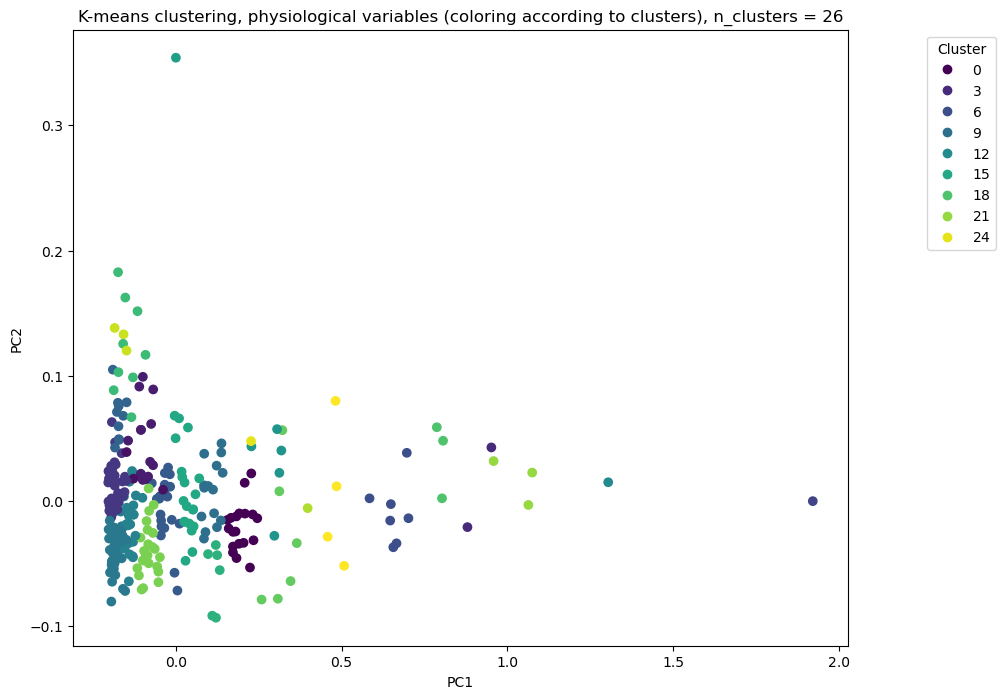

In [48]:
# Perform PCA to reduce the dimensionality of the data to 2 dimensions
pca = PCA(n_components=2)
only_physio_pca = pca.fit_transform(only_physio_np)

# Visualize the clusters
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the data points colored by cluster
scatter = ax.scatter(only_physio_pca[:, 0], only_physio_pca[:, 1], c=labels_KM_physio, cmap='rainbow')

# Plot the centroids
#ax.scatter(centroids_physio[:, 0], centroids_physio[:, 1], marker='x', s=200, linewidths=3, color='r')

# Add a colorbar for the legend
legend = ax.legend(*scatter.legend_elements(), title='Cluster', loc='upper right', bbox_to_anchor=(1.2, 1))

# Set the axis labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('K-means clustering, physiological variables (coloring according to clusters), n_clusters = 26')


# Show the plot
plt.show()

In [49]:
# Create a dictionary for each of the participants
ids = norm_signals['participant'].unique().tolist()
participant_colors = dict(zip(ids, np.arange(1, len(ids) + 1)))


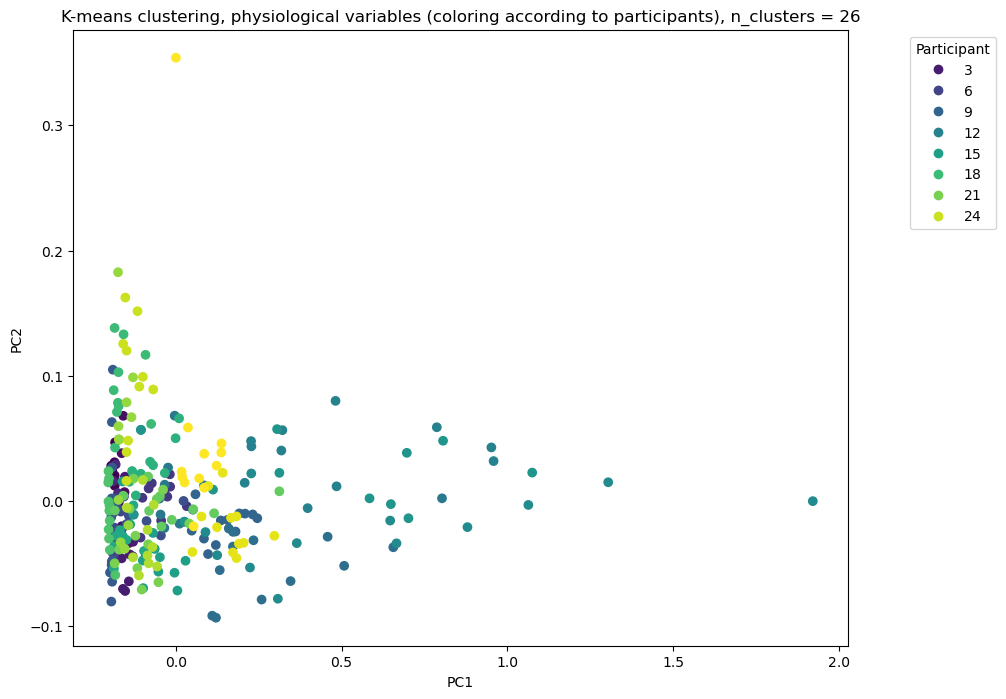

In [50]:
# create a list of colors for each data point based on the 'participant' column
colors = [participant_colors[participant] for participant in norm_signals['participant']]

# plot the data points colored by participant
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(only_physio_pca[:, 0], only_physio_pca[:, 1], c=colors, cmap='rainbow')
legend = ax.legend(*scatter.legend_elements(), title='Participant', loc='upper right', bbox_to_anchor=(1.2, 1))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('K-means clustering, physiological variables (coloring according to participants), n_clusters = 26')

plt.show()



#### Questionnaire variables

In [51]:
question_np = question.to_numpy()

# Fit the KMeans model on the data
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(question_np)

# Get the cluster labels and centroids
labels_KM_question = kmeans.labels_
centroids_KM_question = kmeans.cluster_centers_

# Add cluster labels

norm_signals = norm_signals.assign(cluster_quest=labels_KM_question)


C:\Users\34649\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\34649\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


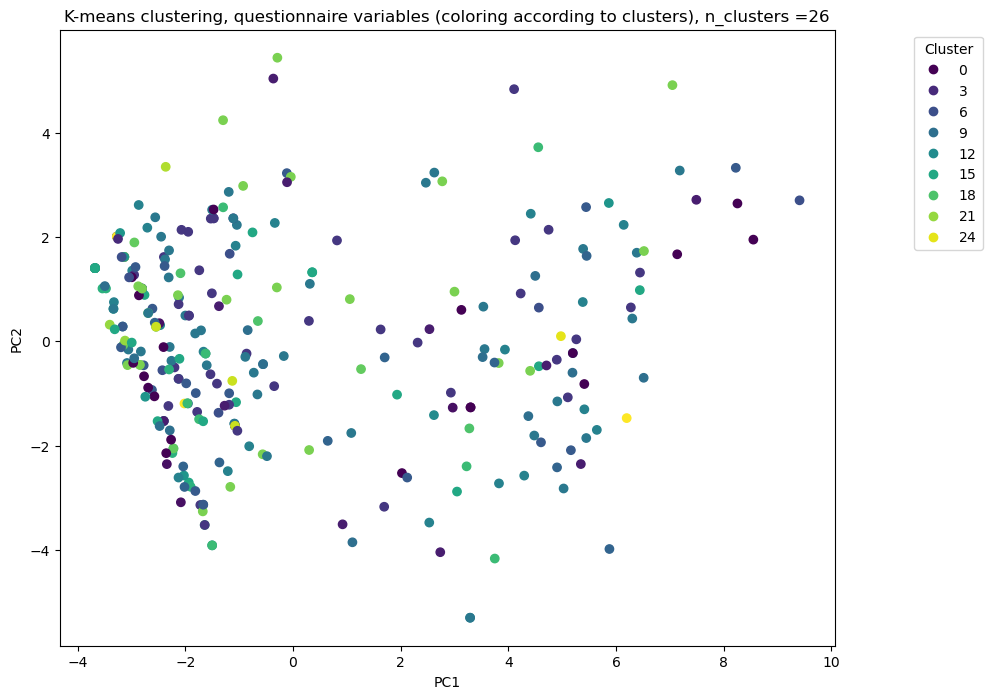

In [52]:
# Perform PCA to reduce the dimensionality of the data to 2 dimensions
pca = PCA(n_components=2)
question_pca = pca.fit_transform(question_np)

# Visualize the clusters
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the data points colored by cluster
scatter = ax.scatter(question_pca[:, 0], question_pca[:, 1], c=labels_KM_physio, cmap='rainbow')

# Plot the centroids
#ax.scatter(centroids_physio[:, 0], centroids_physio[:, 1], marker='x', s=200, linewidths=3, color='r')

# Add a colorbar for the legend
legend = ax.legend(*scatter.legend_elements(), title='Cluster', loc='upper right', bbox_to_anchor=(1.2, 1))

# Set the axis labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('K-means clustering, questionnaire variables (coloring according to clusters), n_clusters =26')


# Show the plot
plt.show()

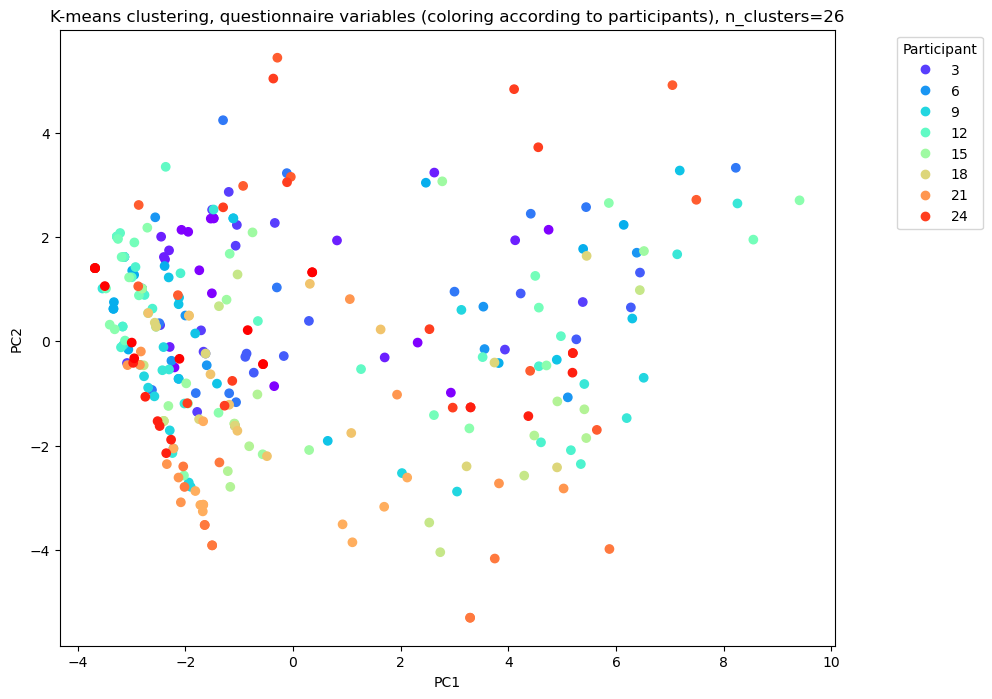

In [24]:
# create a list of colors for each data point based on the 'participant' column
colors = [participant_colors[participant] for participant in norm_signals['participant']]

# plot the data points colored by participant
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(question_pca[:, 0], question_pca[:, 1], c=colors, cmap='rainbow')
legend = ax.legend(*scatter.legend_elements(), title='Participant', loc='upper right', bbox_to_anchor=(1.2, 1))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('K-means clustering, questionnaire variables (coloring according to participants), n_clusters=26')

plt.show()

In [25]:
# # Create a dictionary for each of the participants

# markers = {'D1_0_id1': 'o', 
#            'D1_0_id2': 's', 
#            'D1_0_id3': '^', 
#            'D1_0_id4': 'p', 
#            'D1_0_id5': '*', 
#            'D1_0_id6': 'h', 
#            'D1_0_id7': 'v', 
#            'D1_0_id8': 'D', 
#            'D2_0_id1': 'd', 
#            'D2_0_id2': '8', 
#            'D2_0_id3': '>', 
#            'D2_0_id4': '<', 
#            'D2_0_id5': 'H', 
#            'D2_0_id6': 'x', 
#            'D3_1_id1': '+', 
#            'D3_1_id2': '1', 
#            'D3_1_id3': '2', 
#            'D3_1_id4': '3', 
#            'D3_2_id1': '4', 
#            'D3_2_id2': '5', 
#            'D3_2_id3': '6', 
#            'D3_2_id4': '7', 
#            'D3_3_id1': 'm', 
#            'D3_3_id2': 'M', 
#            'D3_4_id1': 'l', 
#            'D3_4_id2': 'L'}


#### ARI measure

The Adjusted Rand Index (ARI) is a measure of the similarity between two clusterings of the same data. It takes a value between -1 and 1, where a value of 1 indicates perfect agreement between the two clusterings, a value of 0 indicates random clustering, and a value of -1 indicates complete disagreement between the two clusterings.

In [26]:
ari = adjusted_rand_score(norm_signals['cluster_physio'], norm_signals['cluster_quest'])
ari

0.023234391506179525

### 4.1. n_clusters = 3 (types of phases)

In [27]:
n_clusters = 3

#### Physiological variables

C:\Users\34649\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\34649\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


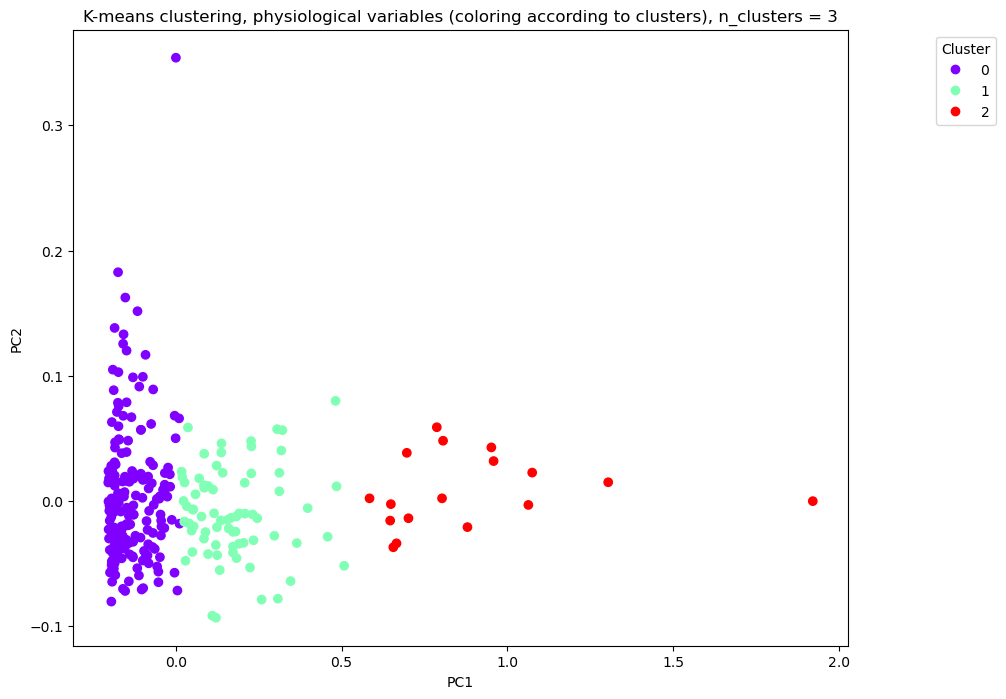

In [28]:
only_physio_np = only_physio.to_numpy()

# Fit the KMeans model on the data
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(only_physio_np)

# Get the cluster labels and centroids
labels_KM_physio = kmeans.labels_
centroids_KM_physio = kmeans.cluster_centers_

# New column in the dataframe
norm_signals = norm_signals.assign(cluster_physio=labels_KM_physio)


# Perform PCA to reduce the dimensionality of the data to 2 dimensions
pca = PCA(n_components=2)
only_physio_pca = pca.fit_transform(only_physio_np)

# Visualize the clusters
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the data points colored by cluster
scatter = ax.scatter(only_physio_pca[:, 0], only_physio_pca[:, 1], c=labels_KM_physio, cmap='rainbow')

# Plot the centroids
#ax.scatter(centroids_physio[:, 0], centroids_physio[:, 1], marker='x', s=200, linewidths=3, color='r')

# Add a colorbar for the legend
legend = ax.legend(*scatter.legend_elements(), title='Cluster', loc='upper right', bbox_to_anchor=(1.2, 1))

# Set the axis labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('K-means clustering, physiological variables (coloring according to clusters), n_clusters = 3')


# Show the plot
plt.show()

In [29]:
# Create a dictionary for each of the phases
ids = norm_signals['Phase'].unique().tolist()
participant_colors = dict(zip(ids, np.arange(1, len(ids) + 1)))

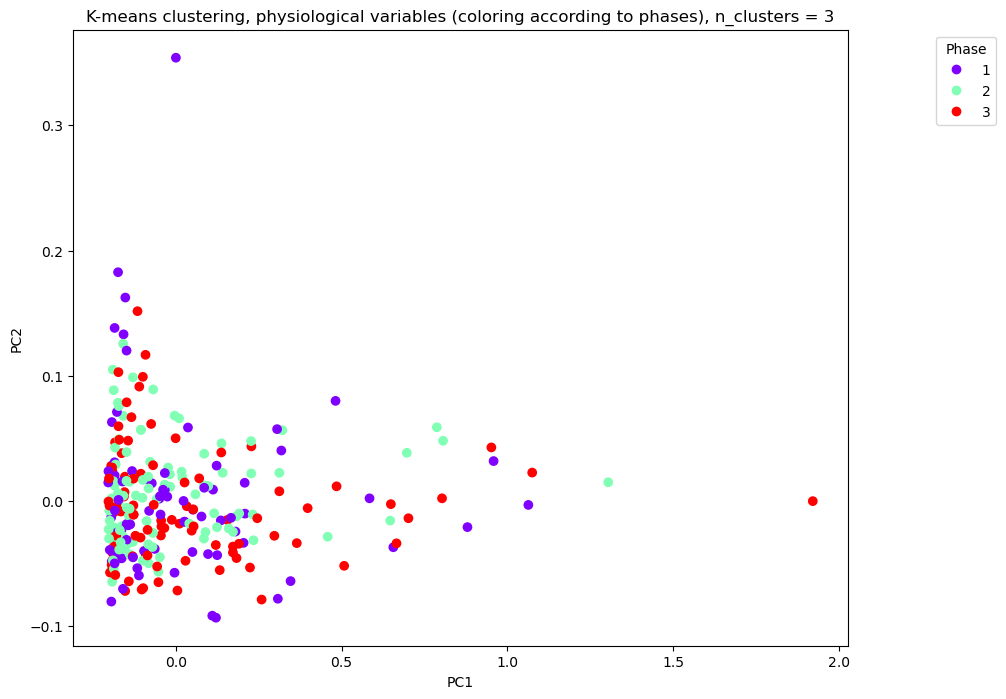

In [47]:
# create a list of colors for each data point based on the 'Phase' column
colors = [participant_colors[participant] for participant in norm_signals['Phase']]

# plot the data points colored by participant
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(only_physio_pca[:, 0], only_physio_pca[:, 1], c=colors, cmap='rainbow')
legend = ax.legend(*scatter.legend_elements(), title='Phase', loc='upper right', bbox_to_anchor=(1.2, 1))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('K-means clustering, physiological variables (coloring according to phases), n_clusters = 3')

plt.show()



#### Questionnaire variables

In [31]:
question_np = question.to_numpy()

# Fit the KMeans model on the data
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(question_np)

# Get the cluster labels and centroids
labels_KM_question = kmeans.labels_
centroids_KM_question = kmeans.cluster_centers_

# Add cluster labels

norm_signals = norm_signals.assign(cluster_quest=labels_KM_question)


C:\Users\34649\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\34649\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


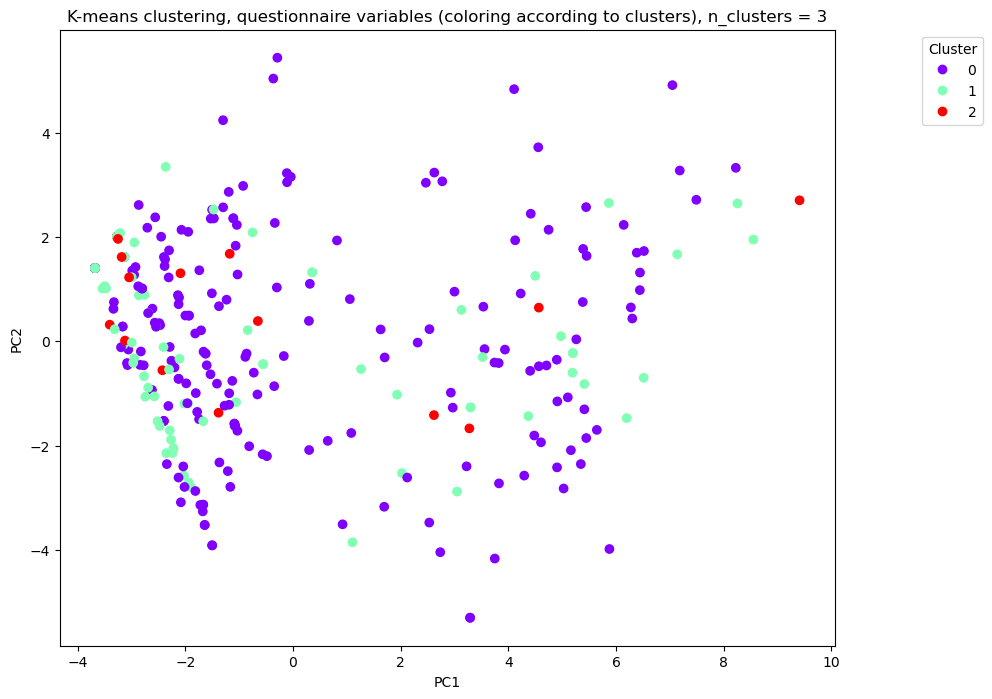

In [32]:
# Perform PCA to reduce the dimensionality of the data to 2 dimensions
pca = PCA(n_components=2)
question_pca = pca.fit_transform(question_np)

# Visualize the clusters
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the data points colored by cluster
scatter = ax.scatter(question_pca[:, 0], question_pca[:, 1], c=labels_KM_physio, cmap='rainbow')

# Plot the centroids
#ax.scatter(centroids_physio[:, 0], centroids_physio[:, 1], marker='x', s=200, linewidths=3, color='r')

# Add a colorbar for the legend
legend = ax.legend(*scatter.legend_elements(), title='Cluster', loc='upper right', bbox_to_anchor=(1.2, 1))

# Set the axis labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('K-means clustering, questionnaire variables (coloring according to clusters), n_clusters = 3')


# Show the plot
plt.show()

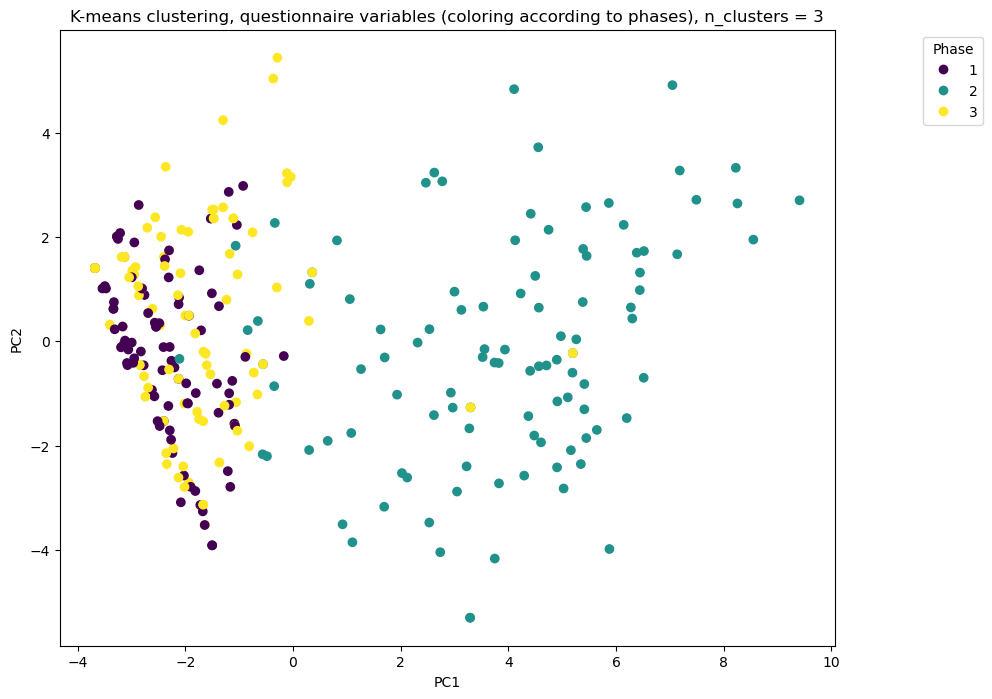

In [33]:
# create a list of colors for each data point based on the 'participant' column
colors = [participant_colors[participant] for participant in norm_signals['Phase']]

# plot the data points colored by participant
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(question_pca[:, 0], question_pca[:, 1], c=colors, cmap='rainbow')
legend = ax.legend(*scatter.legend_elements(), title='Phase', loc='upper right', bbox_to_anchor=(1.2, 1))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('K-means clustering, questionnaire variables (coloring according to phases), n_clusters = 3')

plt.show()

# 'PuOr', 'RdGy', 'RdBu', 'PiYG', 'PRGn', 'BrBG', 'seismic', 'coolwarm', and 'spectral'

In [34]:
ari = adjusted_rand_score(norm_signals['cluster_physio'], norm_signals['cluster_quest'])
ari

-0.010584946673737263

# 5. Spectral clustering

### 5.1 n_clusters=26 (number of participants)


In [97]:
n_clusters = 26

#### Physiological variables

C:\Users\34649\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


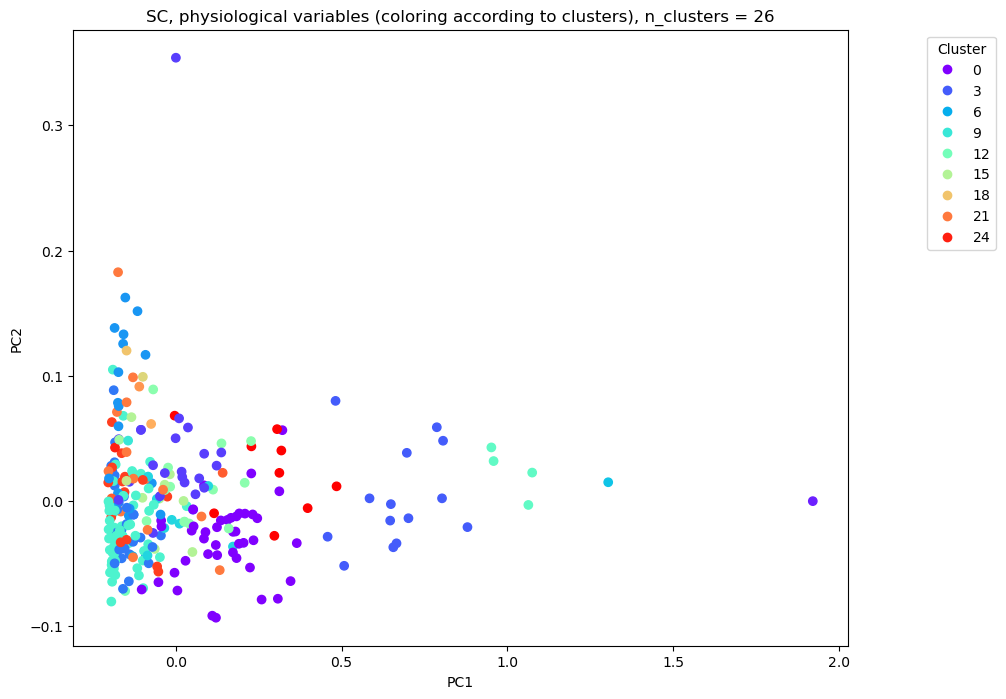

In [98]:
only_physio_np = only_physio.to_numpy()

# Fit the KMeans model on the data
sc = SpectralClustering(n_clusters=n_clusters, affinity='rbf', gamma=1.0)

#sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=10)
cluster_labels = sc.fit_predict(only_physio_np)

# Add the clusters as a column of the original df
norm_signals = norm_signals.assign(SC_cluster_physio=cluster_labels)


# Perform PCA to reduce the dimensionality of the data to 2 dimensions
pca = PCA(n_components=2)
only_physio_pca = pca.fit_transform(only_physio_np)

# Visualize the clusters
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the data points colored by cluster
scatter = ax.scatter(only_physio_pca[:, 0], only_physio_pca[:, 1], c=cluster_labels, cmap='rainbow')


# Add a colorbar for the legend
legend = ax.legend(*scatter.legend_elements(), title='Cluster', loc='upper right', bbox_to_anchor=(1.2, 1))

# Set the axis labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('SC, physiological variables (coloring according to clusters), n_clusters = 26')


# Show the plot
plt.show()

#### Questionnaire variables

C:\Users\34649\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


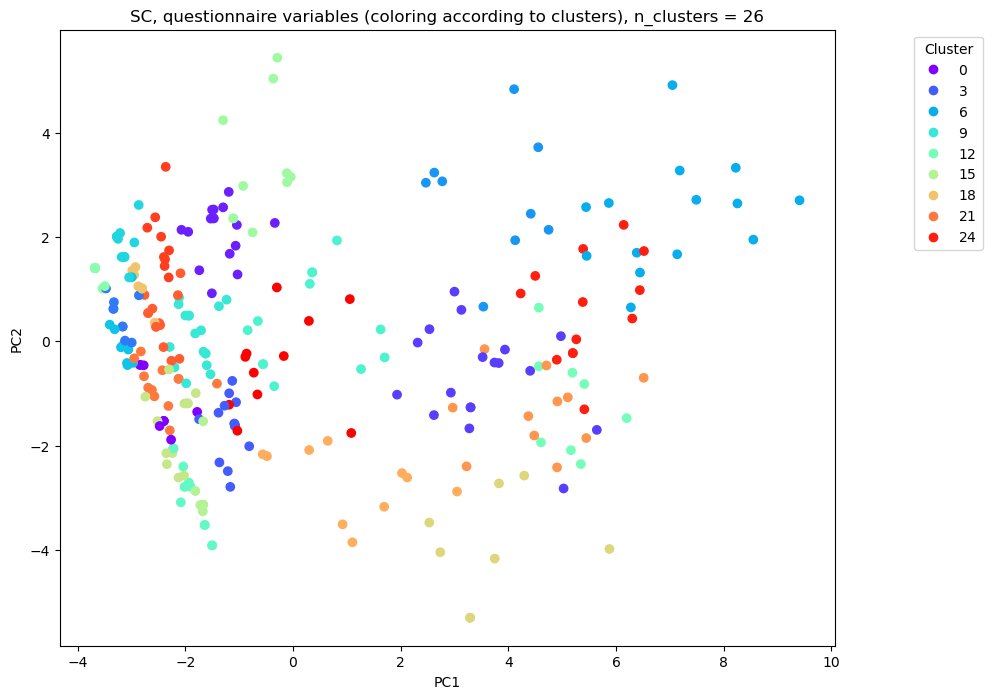

In [99]:
question_np = question.to_numpy()

# Fit the KMeans model on the data

#sc = SpectralClustering(n_clusters=n_clusters, affinity='rbf', gamma=1.0)

sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=10)
cluster_labels = sc.fit_predict(question_np)

# Add the clusters as a column of the original df
norm_signals = norm_signals.assign(SC_cluster_quest=cluster_labels)


# Perform PCA to reduce the dimensionality of the data to 2 dimensions
pca = PCA(n_components=2)
only_physio_pca = pca.fit_transform(question_np)

# Visualize the clusters
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the data points colored by cluster
scatter = ax.scatter(only_physio_pca[:, 0], only_physio_pca[:, 1], c=cluster_labels, cmap='rainbow')


# Add a colorbar for the legend
legend = ax.legend(*scatter.legend_elements(), title='Cluster', loc='upper right', bbox_to_anchor=(1.2, 1))

# Set the axis labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('SC, questionnaire variables (coloring according to clusters), n_clusters = 26')


# Show the plot
plt.show()

In [100]:
ari = adjusted_rand_score(norm_signals['SC_cluster_physio'], norm_signals['SC_cluster_quest'])
ari

0.026110767588464586

### 5.2 n_clusters=3 (number of phases)


In [101]:
n_clusters = 3

#### Physiological variables

C:\Users\34649\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


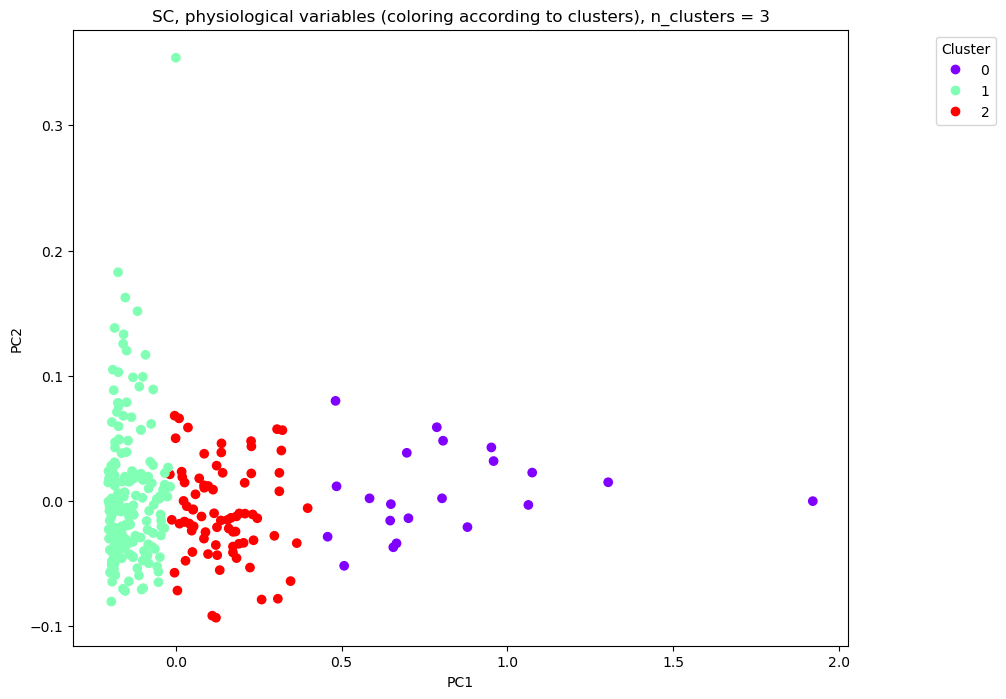

In [102]:
only_physio_np = only_physio.to_numpy()

# Fit the KMeans model on the data

sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=10)
#sc = SpectralClustering(n_clusters=n_clusters, affinity='rbf', gamma=1.0)

cluster_labels = sc.fit_predict(only_physio_np)

# Add the clusters as a column of the original df
norm_signals = norm_signals.assign(SC_cluster_physio=cluster_labels)


# Perform PCA to reduce the dimensionality of the data to 2 dimensions
pca = PCA(n_components=2)
only_physio_pca = pca.fit_transform(only_physio_np)

# Visualize the clusters
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the data points colored by cluster
scatter = ax.scatter(only_physio_pca[:, 0], only_physio_pca[:, 1], c=cluster_labels, cmap='rainbow')


# Add a colorbar for the legend
legend = ax.legend(*scatter.legend_elements(), title='Cluster', loc='upper right', bbox_to_anchor=(1.2, 1))

# Set the axis labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('SC, physiological variables (coloring according to clusters), n_clusters = 3')


# Show the plot
plt.show()

#### Questionnaire variables

C:\Users\34649\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


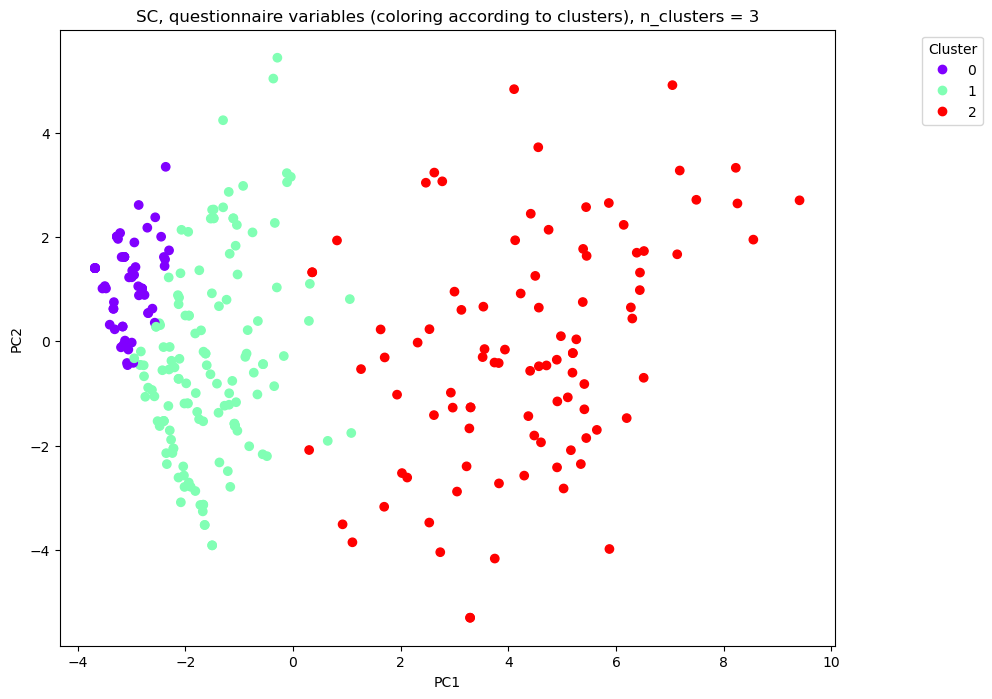

In [105]:
question_np = question.to_numpy()

# Fit the KMeans model on the data


#sc = SpectralClustering(n_clusters=n_clusters, affinity='rbf', gamma=1.0)
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=10)
cluster_labels = sc.fit_predict(question_np)

# Add the clusters as a column of the original df
norm_signals = norm_signals.assign(SC_cluster_quest=cluster_labels)


# Perform PCA to reduce the dimensionality of the data to 2 dimensions
pca = PCA(n_components=2)
only_physio_pca = pca.fit_transform(question_np)

# Visualize the clusters
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the data points colored by cluster
scatter = ax.scatter(only_physio_pca[:, 0], only_physio_pca[:, 1], c=cluster_labels, cmap='rainbow')


# Add a colorbar for the legend
legend = ax.legend(*scatter.legend_elements(), title='Cluster', loc='upper right', bbox_to_anchor=(1.2, 1))

# Set the axis labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('SC, questionnaire variables (coloring according to clusters), n_clusters = 3')


# Show the plot
plt.show()

In [104]:
ari = adjusted_rand_score(norm_signals['SC_cluster_physio'], norm_signals['SC_cluster_quest'])
ari

0.037456273353847776